# Interacting with CerebralCortex Data

Cerebral Cortex is MD2K's big data cloud tool designed to support population-scale data analysis, visualization, model development, and intervention design for mobile sensor data. It provides the ability to do machine learning model development on population scale data sets and provides interoperable interfaces for aggregation of diverse data sources.

This page provides an overview of the core Cerebral Cortex operations to familiarilze you with how to discover and interact with different sources of data that could be contained within the system.

Note: While some of these examples are showing generated data, they are designed to function on real-world mCerebrum data and the signal generators were built to facilitate the testing and evaluation of the Cerebral Cortex platform by those individuals that are unable to see those original datasets.

## Import packages
Python projects always require a number of imports and the specifics are located in the `util/dependencies.py` file.  The `settings` import specifies the specific `USER_ID` that it utilized within the system.  These _ids_ are the unique user identifiers within Cerebral Cortex.

In [1]:
%reload_ext autoreload
from util.dependencies import *
from settings import USER_ID

SyntaxError: invalid syntax (authentication_api.py, line 143)

## Create CerebralCortex object
The __Kernel__ object is the main entry point to the Cerebral Cortex system and it is necessary to pass in a configuration directory that tells it all the different parameters it needs to communicate with all of its other components.  You can exampine the details of these configurations for this server by looking at the files contained in the `conf` folder.

In [3]:
CC = Kernel("/home/md2k/cc_conf/")

## Getting help
These are the typical ways to learn more about the code and objects within Cerebral Cortex.
1. Intelligent context help by typing the object or class into a cell followed by the period, `.`, then when you press `<tab>` a popup will appear showing additional information about the object or method.
2. Formatting the commands with a question mark retrieves the documentation strings and examples when appropriate.  `? CC.list_streams`
3. Reading the documentation on our site: https://cerebralcortex-kernel.readthedocs.io/en/latest/

In [3]:
# CC.

? CC.list_streams


## Generate some sample phone battery data
This helper method utilizes Cerebral Cortex (`CC`), the `USER_ID`, and a `stream_name` to generate fake data for for the purposes of these examples.  If you have real-world data, this step can be skipped and your stream names adjusted to make your dataset.

In [3]:
setup_sample_data(CC, user_id=USER_ID, stream_name="BATTERY--org.md2k.phonesensor--PHONE")

## List available streams in CC
One of the first things a researcher wants to know is what information is available to explore.  The kernel offers a couple of methods to facilitate this and the first, `list_streams`, is to list all the streams within the system.  For larger deployments, this list may be too large to easily sort through or you are interested in a specific type of information where the `search_stream` capability would be more applicable.

In [4]:
streams = CC.list_streams()
for stream in streams:
    print(stream.name)

ACCELEROMETER--org.md2k.cerebralcortex.test
accelerometer--org.md2k.phonesensor--phone
accelerometer--org.md2k.phonesensor--phone_gaussian_noise
BATTERY--org.md2k.phonesensor--PHONE
BATTERY--org.md2k.phonesensor--PHONE
BATTERY--org.md2k.phonesensor--PHONE
BATTERY--org.md2k.phonesensor--PHONE
PHONE-BATTERY-STREAM
string
string22
stringqwd


### Search streams by name
This search returns streams that have a substring match of the search string.

In [5]:
results = CC.search_stream("battery")
for result in results:
    print(result)

BATTERY--org.md2k.phonesensor--PHONE
BATTERY--org.md2k.phonesensor--PHONE
PHONE-BATTERY-STREAM


## Get stream data
Once a stream is identifier by name, it needs to be loaded into a `DataStream` object by calling `get_stream`.  This pulls into a single object all the metadata associated with the stream as well as a reference to the data so that it can be accessed as needed.

In [5]:
data_stream = CC.get_stream("BATTERY--org.md2k.phonesensor--PHONE")

## Print stream data
Any datastream can be printed or visualized to screen; however, it is important to limit, in this case to 3, the number of rows to show.  Streams can contain millions to billions of samples depending on the size of the system and even for the case of a single individual wearing a motion-capture band, this number can exceed 30,000,000 samples for a short 2 week study.  Cerebral Cortex defaults to settings that try to not load all the data unless needed.

This example is printing our the first 3 rows of the loaded battery stream and it contains 5 columns. **(TWH: Fix generator to generate the missing columns)**
- __timestamp__: This is the time in UTC that the sample was recorded at
- __localtime__: This is the time in the local timezone that the sample was recorded at
- __battery_level__: This is the battery percentage of the smartphone device
- __version__: This is the Cerebral Cortex version code assigned to this stream.
- __user__: This is the specific UUID that identifies the user that owns this data point

In [7]:
data_stream.show(3, truncate=False) 

+-------------------+-------------+-------+------------------------------------+
|timestamp          |battery_level|version|user                                |
+-------------------+-------------+-------+------------------------------------+
|2019-01-09 11:49:28|92           |1      |00000000-afb8-476e-9872-6472b4e66b68|
|2019-01-09 11:49:29|92           |1      |00000000-afb8-476e-9872-6472b4e66b68|
|2019-01-09 11:49:30|92           |1      |00000000-afb8-476e-9872-6472b4e66b68|
+-------------------+-------------+-------+------------------------------------+
only showing top 3 rows



## Print stream metadata
Each stream contains 

- __name__: The complete string name of this stream
- __description__: A text description of this stream
- __data_descriptor__: A list of objects that describe the data components of the stream (e.g. battery_level)
    - ...
    - __name__: data descriptor name
    - __type__: the object type (e.g. integer, float, string, ...)
    - __optional_fields__: any number of arbitrary fields can be added when creating a stream and will appear here 
    - ...
- __modules__
    - **<TODO> DETAILS HERE TWH**

In [6]:
metadata = data_stream.get_metadata(version=1)
print(metadata)

{'name': 'BATTERY--org.md2k.phonesensor--PHONE', 'description': 'mobile phone battery sample data stream.', 'metadata_hash': 'e13a1c01-ea2f-3d72-9303-64787d9ff80a', 'input_streams': [], 'annotations': [], 'data_descriptor': [<cerebralcortex.core.metadata_manager.stream.data_descriptor.DataDescriptor object at 0x7f4b1f847b70>], 'modules': [<cerebralcortex.core.metadata_manager.stream.module_info.ModuleMetadata object at 0x7f4b1f847ba8>], 'version': 1}


## Filter Data

Cerebral Cortex returns all data associated with a stream name which is great for performing operations and intial exploration; however, it allows for the filtering of these streams of data to isolate certain criterias.

### Filter data by data column
The first major filtering capability allows for named columns to have logical operations applied to them. The `filter` method is applicable to the data stream object and accepts three parameters.  
- column name: (e.g. battery_level)
- operation: (e.g. >, <, ==, >=, ...)
- criteria: (e.g. 97)



In [9]:
filtered_data = data_stream.filter("battery_level", ">", 97)
filtered_data.show(3,False)

+-------------------+-------------+-------+------------------------------------+
|timestamp          |battery_level|version|user                                |
+-------------------+-------------+-------+------------------------------------+
|2019-01-09 11:39:08|98           |1      |00000000-afb8-476e-9872-6472b4e66b68|
|2019-01-09 11:39:09|98           |1      |00000000-afb8-476e-9872-6472b4e66b68|
|2019-01-09 11:39:10|98           |1      |00000000-afb8-476e-9872-6472b4e66b68|
+-------------------+-------------+-------+------------------------------------+
only showing top 3 rows



### Filter data by user
User filtering is a special case due to the way Cerebral Cortex stores data and a dedicated method, `filter_user`, is provided which accepts a single `USER_ID` as input.  This example illustrate filtering by the earlier provided user id.

In [10]:
filtered_user_data = data_stream.filter_user(USER_ID)
filtered_user_data.show(3,False)

+-------------------+-------------+-------+------------------------------------+
|timestamp          |battery_level|version|user                                |
+-------------------+-------------+-------+------------------------------------+
|2019-01-09 11:49:28|92           |1      |00000000-afb8-476e-9872-6472b4e66b68|
|2019-01-09 11:49:29|92           |1      |00000000-afb8-476e-9872-6472b4e66b68|
|2019-01-09 11:49:30|92           |1      |00000000-afb8-476e-9872-6472b4e66b68|
+-------------------+-------------+-------+------------------------------------+
only showing top 3 rows



### Filter data by version
Versiion filtering is a special case due to the way Cerebral Cortex stores data and a dedicated method, `filter_version`, is provided which accepts a single version as input. **TWH: Why is this a string input and not a int?**

In [11]:
filtered_version_data = data_stream.filter_version("1")
filtered_version_data.show(3,False)

+-------------------+-------------+-------+------------------------------------+
|timestamp          |battery_level|version|user                                |
+-------------------+-------------+-------+------------------------------------+
|2019-01-09 11:49:28|92           |1      |00000000-afb8-476e-9872-6472b4e66b68|
|2019-01-09 11:49:29|92           |1      |00000000-afb8-476e-9872-6472b4e66b68|
|2019-01-09 11:49:30|92           |1      |00000000-afb8-476e-9872-6472b4e66b68|
+-------------------+-------------+-------+------------------------------------+
only showing top 3 rows



## Convert stream data object into Pandas data object
The data representations and visualizations that have been shown so far provide a way for data inspections; however, these are not directly suitable for more complex interactions or analysis.  Cerebral Cortex provide a `to_pandas` method to transform the datastream data into a [Pandas](https://pandas.pydata.org/) dataframe object. From this point, anything that Pandas can do is supported.


In [2]:
pdf = data_stream.to_pandas()
pdf.data

NameError: name 'data_stream' is not defined

## Plot stream data
Visualization is a key part to gaining an understanding of the data and performing data analysis.  The data stream contains a set of basic ploting operations that are accessible through the `.plot()` method or through dedicated mechanisms.  Please see the `plotting_demo` tutorial page for a complete set of plotting examples

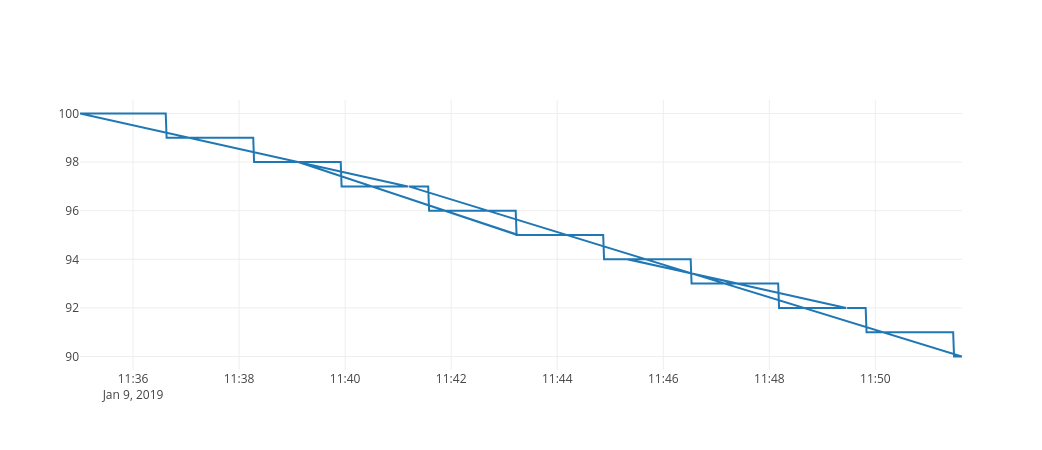

In [4]:
data_stream.plot()

## Compute some basic stats
Cerebral Cortex provides computationally effient helper functions for computing basic statistics over the data stream. These are the methods include: _average, sqrt, sum, variance, stddev, min, max_

**TWH: Why windows? why 60s? how do I control this?**
**TWH I think this needs more fleshing out**

In [3]:
average = data_stream.compute_average()
average.show(4, False)

minimum = data_stream.get_min()
minimum.show(4, False)

## Perform windowing operation on data
Many times it is preferable to group the data into windows before applying an algorithm or computation to the data.  The basic windowing function groups data into non-overlapping chunks and returns a data stream with each cell containing all the data associated with that particular window.

In [15]:
windowed_data = data_stream.window(windowDuration=60)
windowed_data.show(3, True)

### Sliding windows
Another common windowing technique can be accomplished by adding an `offset` parameter to the parameter list to cause the windows to move by a partial window size instead of the whole window.

In [15]:
windowed_data = data_stream.window(windowDuration=60, offset=5)
windowed_data.show(3, True)

## Computation over windows
There are two mechanisms where windowed data can have computation applied.  First, some of the core methods such as `compute_average` or `compute_variance` contain optimized implementations of these algorithms which more efficiently computes the desired outcome by internally applying the windowing algorithms.  Second, a more generic approach comes from explicitly creating the windows and applying a particular computation to it.

In [15]:
average = data_stream.compute_average(windowsDuration=60)
average.show(4, False)


average = data_stream.window(windowsDuration=60).compute(average)
average.show(4, False)

+--------------------+-------+--------------------+--------------------+
|                user|version|              window|       battery_level|
+--------------------+-------+--------------------+--------------------+
|00000000-afb8-476...|      1|[2019-01-09 11:45...|[94, 94, 94, 94, ...|
|00000000-afb8-476...|      1|[2019-01-09 11:41...|[97, 97, 97, 97, ...|
|00000000-afb8-476...|      1|[2019-01-09 11:44...|[95, 95, 95, 95, ...|
+--------------------+-------+--------------------+--------------------+
only showing top 3 rows

